# Testing with Automatic ML selection

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


import sys; sys.path.append("../../")
from modules.utils import load_yaml, load_pkl, make_directory, save_pkl, save_yaml

# Read Data

Note: in the submission, we cannot use `test.csv`. This has no labels and it is for submission only. So we need to use validation data as the test

--> This should be OK since the data size seems large enough

In [2]:
TRAIN_CONFIG_PATH = '../../config/train_config.yaml'
DATA_PATH = '../../data/01_split/'

config = load_yaml(TRAIN_CONFIG_PATH)
LABEL_ENCODING = config['LABEL_ENCODING']

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'valid.csv'))

../../config/train_config.yaml


## Split into train and test

As said, we will use val and test as the same 

In [3]:
train_X, train_y = train_df.loc[:,train_df.columns!='leaktype'], train_df['leaktype']
valid_X, valid_y = valid_df.loc[:,train_df.columns!='leaktype'], valid_df['leaktype']

train_y = train_y.replace(LABEL_ENCODING)
valid_y = valid_y.replace(LABEL_ENCODING)

# Same testing and validation
test_X, test_y = valid_X, valid_y

# Metrics evaluation

We need to get a few metrics right

In [4]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, plot_roc_curve


encoding_to_label = {v: k for k, v in LABEL_ENCODING.items()}
labels = [key for key in LABEL_ENCODING.keys()]

# accuracy = accuracy_score(test_y, pred_y)
# print(f'Mean accuracy score: {accuracy:.3}')


# f1 = f1_score(test_y, pred_y, average='macro')
# print('f1 score :', f1)

# print(classification_report(test_y, pred_y, target_names=labels))

## Classification plotting

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, plot_roc_curve


def plot_confusion_matrix(y_test, y_pred, classes, title='',
                          normalize=False,
                          cmap='Blues',
                          linecolor='k'):
    
    cm = np.array(confusion_matrix(y_test, y_pred))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_title = 'Confusion matrix, with normalization'
    else:
        cm_title = title

    fmt = '.3f' if normalize else 'd'
    sns.heatmap(cm, fmt=fmt, annot=True, square=True,
                xticklabels=classes, yticklabels=classes,
                cmap=cmap,
                linewidths=0.5, linecolor=linecolor,
                cbar=False)
    sns.despine(left=False, right=False, top=False, bottom=False)

    plt.title(cm_title)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()


def pretty_classification_report(y_test, y_pred, labels=None, cmap='viridis'):
    df = pd.DataFrame(classification_report(y_pred, 
                                            y_test, digits=2, 
                                            target_names=labels,
                                            output_dict=True)).T
    df['support'] = df.support.apply(int)

    return  df.style.background_gradient(cmap=cmap,
                                subset=pd.IndexSlice['0':'9', :'f1-score'])


## Auto-Sklearn

`pip install auto-sklearn`

In [6]:
%load_ext autoreload
%autoreload 2

import autosklearn.classification


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# import os

# os.environ["OPENBLAS_NUM_THREADS"] = "8"

In [8]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60,
    per_run_time_limit=30,
    n_jobs=4,
    # Each one of the 4 jobs is allocated 8GB
    memory_limit=8192,
    # Bellow two flags are provided to speed up calculations
    # Not recommended for a real implementation
    # initial_configurations_via_metalearning=0,
    # smac_scenario_args={'runcount_limit': 1},
)
automl.fit(train_X, train_y)

[WARNING] [2022-06-08 17:31:45,663:Client-AutoML(1):6d315849-e705-11ec-9656-277e5c64617f] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.


/home/botu/.local/lib/python3.10/site-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/home/botu/.local/lib/python3.10/site-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[ERROR] [2022-06-08 17:32:34,908:asyncio.events] 
Traceback (most recent call last):
  File "/home/botu/.local/lib/python3.10/site-packages/distributed/client.py", line 1406, in _handle_report
    msgs = await self.scheduler_comm.comm.read()
  File "/home/botu/.local/lib/python3.10/site-packages/distributed/comm/inproc.py", line 200, in read
    raise CommClosedError()
distributed.comm.core.CommClosedError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/botu/.local/lib/python3.10/site-packages/distributed/utils.py", line 761, in wrapper
    return await func(*args, **kwargs)
  File "/home/botu/.local/lib/python3.10/site-packages/distributed/client.py", line 1414, in _handle_report
    await self._reconnect()
  File "/home/botu/.local/lib/python3.10/site-packages/distributed/utils.py", line 761, in wrapper
    return await func(*args, **kwargs)
  File "/home/botu/.local/lib/python3.10/site-packages/distributed/client

AutoSklearnClassifier(memory_limit=8192, n_jobs=4, per_run_time_limit=30,
                      time_left_for_this_task=60)

In [9]:
y_automl = automl.predict(test_X)
print("Accuracy score", accuracy_score(test_y, y_automl))

Accuracy score 0.8662202380952381


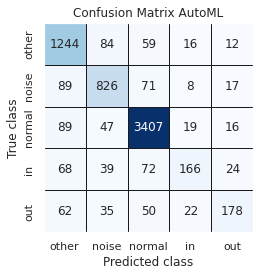

In [10]:
model = 'AutoML'
plot_confusion_matrix(test_y, y_automl, labels,  f'Confusion Matrix {model}')

In [11]:
pretty_classification_report(test_y, y_automl)

,precision,recall,f1-score,support
0,0.879152,0.801546,0.838557,1552
1,0.817013,0.801164,0.809011,1031
2,0.952208,0.931129,0.941550,3659
3,0.449864,0.718615,0.553333,231
4,0.512968,0.720648,0.599327,247
accuracy,0.866220,0.866220,0.866220,0
macro avg,0.722241,0.794620,0.748356,6720
weighted avg,0.881181,0.866220,0.871506,6720


In [12]:
from sklearn.metrics import f1_score

f1 = f1_score(test_y, y_automl, average='macro')
print('F1 score :', f1)

F1 score : 0.7483557076076611
